## UFO Sightings - using built-in Algorithms

The goal of this notebook is to build out models to use for predicting the legitimacy of a UFO sighting using the XGBoost and Linear Learner algorithm.

What we plan on accompishling is the following:
1. [Load dataset onto Notebook instance memory from S3](#Step-1:-Load-the-data-from-Amazon-S3)
1. [Cleaning, transforming, analyize, and preparing the dataset](#Step-2:-Cleaning,-transforming,-analyize,-and-preparing-the-dataset)
1. [Create and train our model (XGBoost)](#Step-3:-Creating-and-training-our-model-(XGBoost))
1. [Create and train our model (Linear Learner)](#Step-4:-Creating-and-training-our-model-(Linear-Learner))

In [1]:
#import all the needed libraries.
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Loading the data from Amazon S3
Let's get the UFO sightings data that is stored in S3 and load it into memory.

In [3]:
#pre-requisites: create S3 bucket, upload files, set IAM roles for Sagemaker to access to S3 bucket

role = get_execution_role()
bucket ='sagemaker-ml-lab-tx'
sub_folder = 'ufo_dataset'
data_key = 'ufo_fullset.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
print(data_location)

s3://sagemaker-ml-lab-tx/ufo_dataset/ufo_fullset.csv


In [41]:
df = pd.read_csv(data_location, low_memory=False)
df.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


<hr>

## Step 2: Cleaning, transforming, analyize, and preparing the dataset


In [5]:
# Check missing values
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


In [6]:
df['shape'].value_counts()

circle      6047
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

In [7]:
# Replace the missing values with the most common shape
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

In [42]:
df.dtypes

reportedTimestamp     object
eventDate             object
eventTime             object
shape                 object
duration               int64
witnesses              int64
weather               object
firstName             object
lastName              object
latitude             float64
longitude            float64
sighting              object
physicalEvidence      object
contact               object
researchOutcome       object
dtype: object

Transforming some of the values into the correct data types
1. Convert the `reportedTimestamp` and `eventDate` to a datetime data types.
1. Convert the `shape` and `weather` to a category data type.
1. Map the `physicalEvidence` and `contact` from 'Y', 'N' to `0`, `1`.
1. Convert the `researchOutcome` to a category data type (target attribute).

In [8]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

df['researchOutcome'] = df['researchOutcome'].astype('category')

In [9]:
df.dtypes

reportedTimestamp    datetime64[ns, UTC]
eventDate                 datetime64[ns]
eventTime                         object
shape                           category
duration                           int64
witnesses                          int64
weather                         category
firstName                         object
lastName                          object
latitude                         float64
longitude                        float64
sighting                          object
physicalEvidence                   int64
contact                            int64
researchOutcome                 category
dtype: object

Let's visualize to see if we can find out any important information.

In [11]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

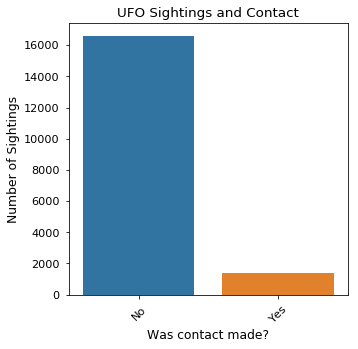

In [12]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

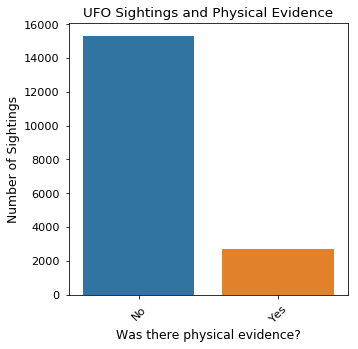

In [13]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Physical Evidence')
ax.set_xlabel('Was there physical evidence?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

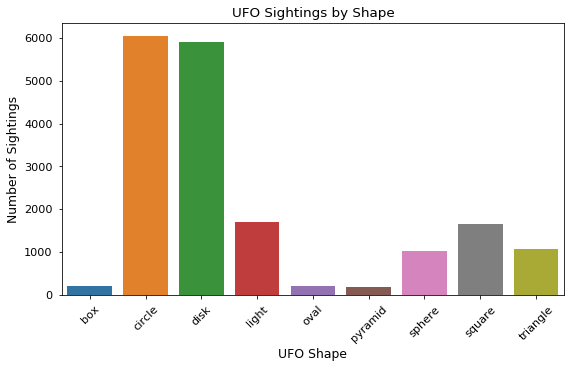

In [14]:
m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(9,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Shape')
ax.set_xlabel('UFO Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

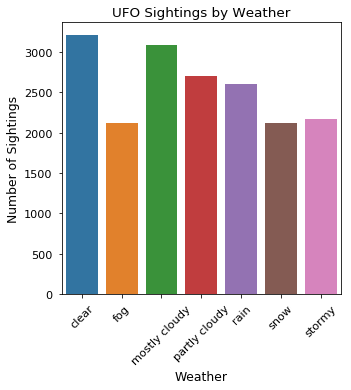

In [15]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Weather')
ax.set_xlabel('Weather')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

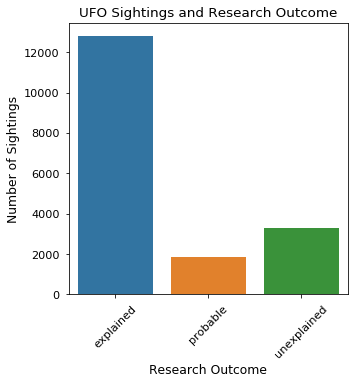

In [16]:
m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.get_values()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Research Outcome')
ax.set_xlabel('Research Outcome')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

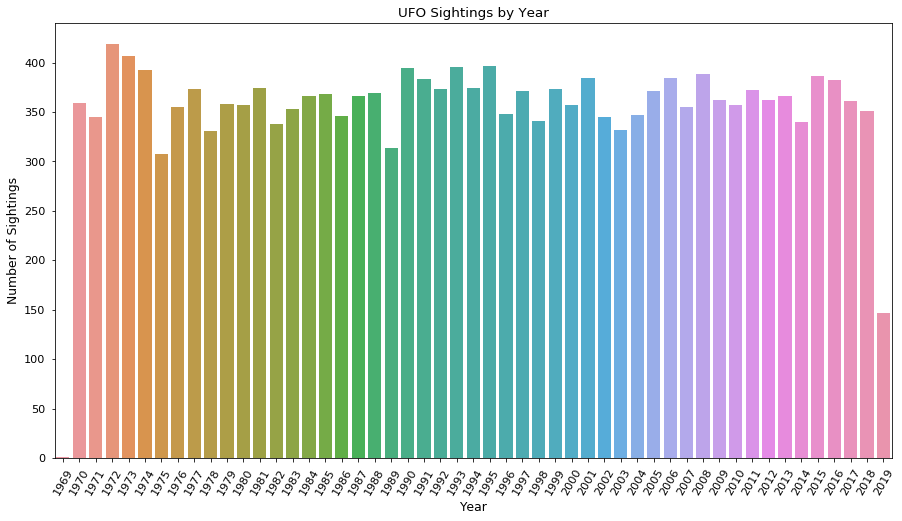

In [17]:
ufo_yr = df['eventDate'].dt.year  # series with the year exclusively

## Set axes ##
years_data = ufo_yr.value_counts()
years_index = years_data.index  # x ticks
years_values = years_data.get_values()

## Create Bar Plot ##
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Year')
plt.ylabel('Number of Sightings')
plt.xlabel('Year')

years_plot = sns.barplot(x=years_index[:60],y=years_values[:60])

In [18]:
df.corr()

,duration,witnesses,latitude,longitude,physicalEvidence,contact
duration,1.000000,0.020679,0.000243,-0.010529,0.016430,0.015188
witnesses,0.020679,1.000000,0.010229,0.003449,0.009186,-0.000651
latitude,0.000243,0.010229,1.000000,-0.394536,0.006465,0.004284
longitude,-0.010529,0.003449,-0.394536,1.000000,-0.004519,-0.004828
physicalEvidence,0.016430,0.009186,0.006465,-0.004519,1.000000,0.693276
contact,0.015188,-0.000651,0.004284,-0.004828,0.693276,1.000000


In [19]:
# Drop `sighting` because it is always 'Y' or Yes. 
# Drop the `firstName` and `lastName` because not important in determining the `researchOutcome`.
# Drop the `reportedTimestamp` because not important in determining the legitimacy of the sighting.
# Drop `eventDate` and `eventTime` because distribution of dates is pretty even

df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [20]:
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


In [21]:
# Encode weather and shape attribute
df = pd.get_dummies(df, columns=['weather', 'shape'])

# Replace the researchOutcome values with 0, 1, 2 for Unexplained, Explained, and Probable
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [22]:
display(df.head())
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


(18000, 23)

<hr>

In [23]:
# randomize our data.
df = df.sample(frac=1).reset_index(drop=True)

# split the data into a training, validation, and testing.
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8                       # 80% for training
val_list = (rand_split >= 0.8) & (rand_split < 0.9) # 10% for validation
test_list = rand_split >= 0.9                       # 10% for testing

 # train the model.
data_train = df[train_list]

# validate the model.
data_val = df[val_list]

# test the model.
data_test = df[test_list]

Re-arrange attributes then stored as CSV - upload them to S3. 

In [24]:
# Move the researchOutcome attribute to the first position before creating CSV files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# upload files to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')


<hr>

## Step 3: Creating and training our model (XGBoost)


In [27]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

In [28]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/algorithms_lab/xgboost_validation'.format(bucket), content_type='csv')


<hr>

In [29]:
# Create a training job name
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/algorithms_lab/xgboost_output'.format(bucket)

Here is the job name ufo-xgboost-job-20200405090230


In [30]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(objective='multi:softmax',
                        num_class=3,
                        num_round=100)

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}
xgb.fit(data_channels, job_name=job_name) 

2020-04-05 09:02:36 Starting - Starting the training job...
2020-04-05 09:02:37 Starting - Launching requested ML instances......
2020-04-05 09:03:40 Starting - Preparing the instances for training......
2020-04-05 09:04:42 Downloading - Downloading input data...
2020-04-05 09:05:32 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[09:05:33] 14426x22 matrix with 317372 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root


2020-04-05 09:05:45 Uploading - Uploading generated training model
2020-04-05 09:05:45 Completed - Training job completed
Training seconds: 63
Billable seconds: 63


In [31]:
print('Here is the location of the trained XGBoost model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained XGBoost model: s3://sagemaker-ml-lab-tx/algorithms_lab/xgboost_output/ufo-xgboost-job-20200405090230/output/model.tar.gz


---

## Step 4: Creating and training our model (Linear Learner)



In [32]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# This rearranges the columns
cols = list(data_train)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_train = data_train[cols]

cols = list(data_val)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_val = data_val[cols]

cols = list(data_test)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_test = data_test[cols]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').as_matrix()
train_y = data_train['researchOutcome'].as_matrix()

val_X = data_val.drop(columns='researchOutcome').as_matrix()
val_y = data_val['researchOutcome'].as_matrix()

test_X = data_test.drop(columns='researchOutcome').as_matrix()
test_y = data_test['researchOutcome'].as_matrix()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.

In [33]:
#create recordIO file for the training data and upload it to S3.
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)
training_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_train/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://sagemaker-ml-lab-tx/algorithms_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data


In [34]:
#create recordIO file for the validation data and upload it to S3
validation_file = 'ufo_sightings_validatioin_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_validation/{}'.format(validation_file)).upload_fileobj(f)
validate_recordIO_protobuf_location = 's3://{}/algorithms_lab/linearlearner_validation/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://sagemaker-ml-lab-tx/algorithms_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


---



In [35]:
#ECR repository to call the Linear Learner algorithm.
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "1")

In [36]:
# Create a training job name
job_name = 'ufo-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = 's3://{}/algorithms_lab/linearlearner_output'.format(bucket)

Here is the job name ufo-linear-learner-job-20200405090836


In [37]:
print('The feature_dim hyperparameter needs to be set to {}.'.format(data_train.shape[1] - 1))

The feature_dim hyperparameter needs to be set to 22.


In [38]:
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')
# Setup the hyperparameters
linear.set_hyperparameters(feature_dim=22, # number of attributes (minus the researchOutcome attribute)
                           predictor_type='multiclass_classifier', # type of classification problem
                           num_classes=3)  # number of classes in out researchOutcome (explained, unexplained, probable)


# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_recordIO_protobuf_location,
    'validation': validate_recordIO_protobuf_location
}
linear.fit(data_channels, job_name=job_name)

2020-04-05 09:09:39 Starting - Starting the training job...
2020-04-05 09:09:41 Starting - Launching requested ML instances......
2020-04-05 09:10:43 Starting - Preparing the instances for training......
2020-04-05 09:12:07 Downloading - Downloading input data
2020-04-05 09:12:07 Training - Downloading the training image..
2020-04-05 09:12:39 Uploading - Uploading generated training model
2020-04-05 09:12:39 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/05/2020 09:12:24 INFO 140579890235200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level':

Training seconds: 56
Billable seconds: 56


In [39]:
print('Here is the location of the trained Linear Learner model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained Linear Learner model: s3://sagemaker-ml-lab-tx/algorithms_lab/linearlearner_output/ufo-linear-learner-job-20200405090836/output/model.tar.gz


#Now we have 2 trained models using XGBoost & Linear Learner